In [1]:
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
np.set_printoptions(suppress=True) 

In [2]:
import os
from keras.preprocessing import image
from keras.utils import np_utils, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

Using TensorFlow backend.


## 準備訓練資料與測試資料

In [5]:
def load_data(path):
    path = path
    files = os.listdir(path)
    images = []
    labels = []
        
    for f in files:
        img_path = path + f
        img = Image.open(img_path)
        width = 48
        height = 64
        img = img.resize( (width, height), Image.BILINEAR )
        img_array = image.img_to_array(img)
        images.append(img_array)
        
        lb = f.split('_')[0]
        labels.append(lb)

    data = np.array(images)
    labels = np.array(labels)

    return data, labels

In [6]:
print ('Loading data...')
data, labels = load_data(path='./train/')
data -= np.mean(data,axis=0)
print ('finish')

Loading data...
finish


## 切分資料
* train
* val
* generator要的資料

In [7]:
Label = np.unique(labels)
le = LabelEncoder()
labels_le = le.fit_transform(labels)

In [8]:
(trainX, valX, trainY, valY) = train_test_split(data, labels_le, test_size=0.1)

trainY_onehot = np_utils.to_categorical(trainY,num_classes=4)
valY_onehot = np_utils.to_categorical(valY,num_classes=4)

labels_le_onehot = np_utils.to_categorical(labels_le, num_classes=4)

In [9]:
print(trainX.shape)
print(valX.shape)
print(trainY_onehot.shape)
print(valY_onehot.shape)
print(labels_le_onehot.shape)

(88, 64, 48, 3)
(10, 64, 48, 3)
(88, 4)
(10, 4)
(98, 4)


## 模型建立

In [3]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout,Activation,BatchNormalization
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [11]:
class MY_CNN(object):
    '''建立一個CNN模型'''
    def __init__(self,in_shape,out_classes):
        
        self.in_shape=in_shape
        self.out_classes=out_classes
        
    def build_model(self):
        '''以Sequential()逐層疊加模型。'''
        
        model = Sequential()
              
        # conv block 1
        model.add(Conv2D(64, (3,3), padding="same",activation="relu",
                                     input_shape=self.in_shape) )
        model.add(Conv2D(64, (3,3), padding="same" ,activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        
        # conv block 2
        model.add(Conv2D(128, (3,3), padding='same',activation="relu"))
        model.add(Conv2D(128, (3,3), padding="same",activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.2))
        # conv block 3
        model.add(Conv2D(256, (3,3), padding='same',activation="relu"))
        model.add(Conv2D(256, (3,3), padding="same",activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.1))
        
         # conv block 4
        model.add(Conv2D(512, (3,3), padding='same',activation="relu"))
        model.add(Conv2D(512, (3,3), padding="same",activation="relu"))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization())
        model.add(Dropout(0.1))

        # dense block
        model.add(Flatten())
        model.add(Dense(1024,activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.01))
        model.add(Dense(1024,activation="relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.01))

        model.add(Dense(self.out_classes))
        model.add(Activation('softmax'))
        return model

## 用generator生圖片fit

In [109]:
""" 產生generator
"""
gen = image.ImageDataGenerator(featurewise_center=True, # 去中心化
                               samplewise_center=False, # 使樣本均值為0
                               rotation_range=45, # 隨機轉動的角度
                               width_shift_range=0.2, # 水平偏移的幅度
                               height_shift_range=0.2, # 垂直偏移的幅度
                               shear_range=0.3, # 剪切強度
                               zoom_range=0.2, # 隨機縮放的強度
                               horizontal_flip=True, # 水平翻轉
                               vertical_flip=True, # 垂直翻轉
                               fill_mode='constant',
                               data_format='channels_last'
                               )
gen.fit(data)
train_generator = gen.flow(data,labels_le_onehot,batch_size=100000)

Epoch 1/5
1000/1000 [==============================] - 201s 201ms/step - loss: 0.0360 - acc: 0.9879 - val_loss: 4.8701e-04 - val_acc: 1.0000
Epoch 2/5
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0781 - val_acc: 0.9000
Epoch 3/5
1000/1000 [==============================] - 198s 198ms/step - loss: 0.0021 - acc: 0.9994 - val_loss: 0.0024 - val_acc: 1.0000
Epoch 4/5
1000/1000 [==============================] - 199s 199ms/step - loss: 3.6573e-04 - acc: 0.9999 - val_loss: 9.0722e-06 - val_acc: 1.0000
Epoch 5/5
1000/1000 [==============================] - 199s 199ms/step - loss: 0.0035 - acc: 0.9991 - val_loss: 1.3709e-07 - val_acc: 1.0000


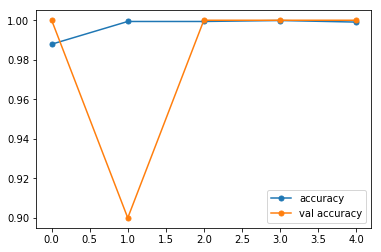

In [110]:
# 取得模型
model=MY_CNN(in_shape=(data.shape[1], data.shape[2], 3),out_classes=4).build_model()
# 編譯模型：給定模型目標和訓練方式。
opt = optimizers.Adam(lr=0.0001)
callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, verbose=0),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')
        ]
model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=["accuracy"])
# 訓練模型
history = model.fit_generator(train_generator,steps_per_epoch=1000,epochs=5,validation_data=(valX,valY_onehot))
# 畫出訓練過程
plt.plot(history.history['acc'],ms=5,marker='o',label='accuracy')
plt.plot(history.history['val_acc'],ms=5,marker='o',label='val accuracy')
plt.legend()
plt.show()

In [45]:
# del model

In [120]:
# 存模型
model.save('Model_5.h5') 
# 載入模型:
#tf.contrib.keras.models.load_model('model.h5')

## test

In [58]:
from sklearn.metrics import confusion_matrix, accuracy_score

In [59]:
print ('Loading data...')
testX, testY = load_data(path='./test/')
testX -= np.mean(testX,axis=0)
print ('finish')

Loading data...
finish


In [60]:
testY_label = testY
le = LabelEncoder()
testY_le = le.fit_transform(testY)

In [61]:
model = tf.contrib.keras.models.load_model('Model_5.h5')

In [62]:
pred = model.predict(testX)

In [63]:
enc = OneHotEncoder()

def props_to_onehot(props):
    if isinstance(props, list):
        props = np.array(props)
    a = np.argmax(props, axis=1)
    b = np.zeros((len(a), props.shape[1]))
    b[np.arange(len(a)), a] = 1
    return b


pred_onehot = props_to_onehot(pred)

pred_le = []
for i in range(len(pred)):
    
    if pred_onehot[i][0] == 1:
        tmp = 0
    elif pred_onehot[i][1] ==1:
        tmp = 1
    elif pred_onehot[i][2] ==1:
        tmp = 2
    else: 
        tmp = 3
    pred_le.append(tmp)

In [64]:
confusion_matrix(testY_le, pred_le)

array([[10,  0,  0,  0],
       [ 0, 10,  0,  0],
       [ 0,  0, 10,  0],
       [ 0,  0,  0, 10]], dtype=int64)

In [65]:
accuracy_score(testY_le, pred_le)

1.0